In [1]:
import torch
import pandas as pd
import numpy as np
import torch.utils
import torchvision.transforms
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

torch.set_printoptions(threshold=10000)

In [2]:
#Loading house prices training and test dataset
hptrain = pd.read_csv("Datasets/hptrain.csv",index_col=0)
hptest = pd.read_csv("Datasets/hptest.csv",index_col=0)

In [3]:
#Transforming data into tensor data format from pandas' dataframe
X_ols_train = torch.tensor(hptrain[['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'TotalBsmtSF']].values,requires_grad=True,dtype=torch.float32)
X_ols_train = nn.functional.normalize(X_ols_train)
Y_ols_train = torch.tensor(hptrain[['SalePrice']].values,requires_grad=True,dtype=torch.float32)


#Splitting data into iterable batches
olstensor = torch.utils.data.TensorDataset(X_ols_train,Y_ols_train)
olsdataloader = torch.utils.data.DataLoader(olstensor, batch_size=20,shuffle=True)

In [4]:
#Specifying the paramenters of our model (ols - ordinary least squares i.e. linear regression)
olsnet = nn.Sequential(nn.Linear(X_ols_train.size()[1],Y_ols_train.size()[1]))
olsnet[0].weight.data.normal_(0, 0.1)
olsnet[0].bias.data.normal_(0, 0.1)
olsloss = nn.MSELoss()
olstrainer = torch.optim.SGD(olsnet.parameters(),lr=0.0001)

In [5]:
num_epochs = 5
olsnet.train()
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    olstrainer.zero_grad()
    X, Y = next(iter(olsdataloader))
    output = olsnet(X)

    l = olsloss(output,Y)
    print(f'Loss ols:{l}')


    l.backward(retain_graph=True)

    olstrainer.step()
    print('Coefficients: ',olsnet[0].weight.data)


-------------------
1th epoch
Loss ols:42911813632.0
Coefficients:  tensor([[3.8242e+01, 2.2751e-02, 1.1537e-01, 7.9643e-01, 4.8422e+00]])
-------------------
2th epoch
Loss ols:66449461248.0
Coefficients:  tensor([[8.6509e+01, 5.1737e-02, 1.3776e-01, 1.5267e+00, 9.8387e+00]])
-------------------
3th epoch
Loss ols:32289910784.0
Coefficients:  tensor([[1.1976e+02, 7.4393e-02, 1.5789e-01, 1.8218e+00, 1.3606e+01]])
-------------------
4th epoch
Loss ols:30630084608.0
Coefficients:  tensor([[1.5251e+02, 9.8573e-02, 1.7833e-01, 1.9972e+00, 1.8296e+01]])
-------------------
5th epoch
Loss ols:44796665856.0
Coefficients:  tensor([[1.9162e+02, 1.3073e-01, 2.0452e-01, 2.9756e+00, 2.3716e+01]])


In [6]:
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [7]:
#Creating a class for displaying the results
class evaluation:
    """For evaluating the accuracy of image recognition neural networks"""
    def __init__(self,net,img = None,label = None):
        #History of saved error rates, used for in-sample error evaluation during neural network training
        self.hist = []
        self.net = net
        self.img = img
        self.label = label

    def prob(self):
        """Returns probabilities for each label"""
        output = self.net(self.img).double()
        exp = torch.exp(output)
        sum = torch.sum(exp,dim=-1)
        probabilities = exp / sum.unsqueeze(1)
        return probabilities

    def pred(self):
        """Returns the labels our model predicted for each image"""
        pred = torch.argmax(self.prob(),dim=1)
        return pred

    def cert(self):
        """(certainty) Returns the probabilities of the chosen label for each image"""
        return torch.amax(self.prob(),dim=1)

    def error(self):
        """Returns missclassificaiton eror rate"""
        return torch.sum(self.pred() != self.label)/len(self.label)

    def add(self,img,label):
        """Appends an error rate (and loss if not None) to the history of error rates (used for in-sample error rate during training)"""
        self.img = img
        self.label = label
        self.hist.append(self.error())


    def __getitem__(self, idx):
        return self.hist[idx]

    def plot(self):
        """Plots the in-sample error and loss (if such has been added) from history"""

        plt.plot(self.hist)
        plt.ylabel('In-sample error')
        plt.xlabel('Epoch')
        plt.show()


In [8]:
#Creating an automatic trainer to be used with sequential linear classes
class Gradient_Trainer:
    """Automatic trainer for linear classifiers embedded through a sequential class"""
    def __init__(self,net,train_iter,loss,trainer,test_iter=None):
        self.net = net
        self.train_iter = train_iter
        self.loss = loss
        self.trainer = trainer
        self.test_iter = test_iter
        self.eval = None

    def reset(self, std = 0.1):
        """Used for resetting the weights of the neural network for retrainment"""
        def init_weights(m):
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=std)

        self.net.apply(init_weights)

    def Train(self,num_epochs,ploss = False,perror = False,graph = False):
        """Used for training the neural network
                :param ploss: - print loss for each epoch
                :param perror: - print error for each epoch
                :param graph: - graph in-sample error at the end of training"""
        self.net.train()
        eval = evaluation(net=self.net)
        for epoch in range(num_epochs):
            if ploss is True or perror is True:
                print('-------------------')
                print(f'{epoch+1}th epoch')
                print('===================')
            self.net.zero_grad()
            img, label = next(iter(self.train_iter))
            output = self.net(img).double()
            l = self.loss(output,label)
            l.mean().backward()
            self.trainer.step()
            eval.add(img,label)
            if ploss is True:
                print("Loss:",l.sum().item())
            if perror is True:
                print("In-sample error:",eval.error())
        if graph is True:
            eval.plot()
        self.eval = eval

    def Test(self,test_iter=None):
        if self.test_iter is None:
            self.test_iter = test_iter
        img, label = next(iter(self.test_iter))
        result = evaluation(net=self.net,img=img,label=label)
        print("Out-of-sample error:",result.error())
        self.result = result

In [9]:
#Loading in complex MNIST train and test datasets while transforming them to 28x28
trans = [torchvision.transforms.ToTensor()]
trans.insert(0, torchvision.transforms.Resize(28))
trans = torchvision.transforms.Compose(trans)


mnist_train = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = True, transform=trans, download= True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = False, transform=trans, download= True)

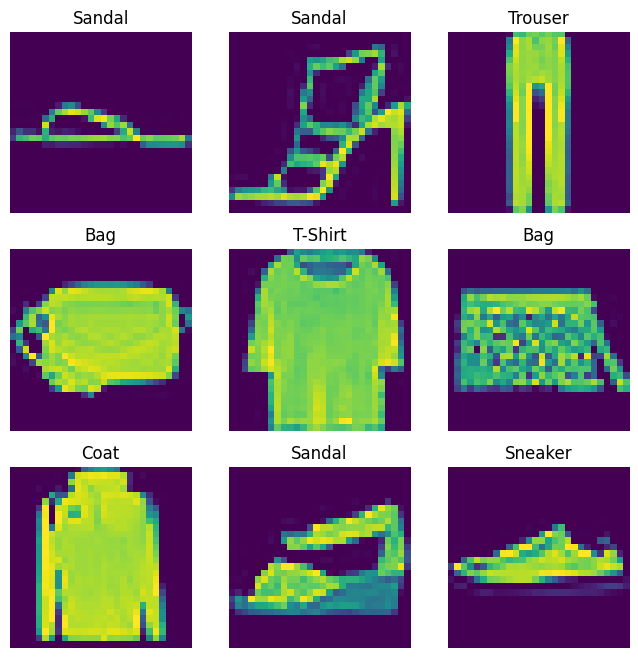

In [10]:
#Visualizing 9 random examples
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    imge, labele = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[labele])
    plt.axis("off")
    plt.imshow(imge.squeeze())
plt.show()

In [11]:
#Splitting our data into batch sizes
mnist_batch_size = 256

mnist_train_iter = torch.utils.data.DataLoader(mnist_train,mnist_batch_size,shuffle=True,num_workers=4)
mnist_test_iter = torch.utils.data.DataLoader(mnist_test,mnist_test.__len__(),shuffle=False,num_workers=4)

In [12]:
#Creating the model and initializing the weights (logit - logistic regression)
logit_net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

#Initializing weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

logit_net.apply(init_weights)

#Specifying cross entropy loss
logit_loss = nn.CrossEntropyLoss(reduction='none')

#Specifying Stochastic Gradient Descent trainer
logit_trainer = torch.optim.SGD(logit_net.parameters(), lr=0.1)

-------------------
1th epoch
Loss: 851.9792899565496
In-sample error: tensor(0.7930)
-------------------
2th epoch
Loss: 614.2489235207797
In-sample error: tensor(0.7188)
-------------------
3th epoch
Loss: 572.9364785570598
In-sample error: tensor(0.7305)


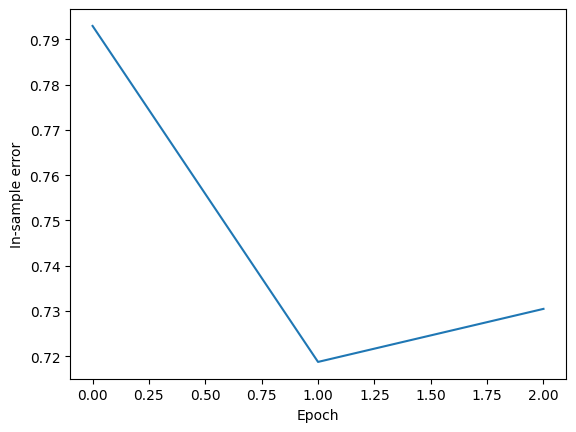

In [13]:
logit_training = Gradient_Trainer(logit_net,mnist_train_iter,logit_loss,logit_trainer,mnist_test_iter)
logit_training.reset()
logit_training.Train(3,True,True,True)

In [14]:
logit_training.eval.hist

[tensor(0.7930), tensor(0.7188), tensor(0.7305)]

In [15]:
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [16]:
#Perceptron initiation

MLP = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

MLP.apply(init_weights)

MLP_loss = nn.CrossEntropyLoss(reduction='none')

MLP_trainer = torch.optim.SGD(MLP.parameters(),lr = 0.1)

-------------------
1th epoch
Loss: 588.7833055794587
In-sample error: tensor(0.8789)
-------------------
2th epoch
Loss: 588.5328964356298
In-sample error: tensor(0.7930)
-------------------
3th epoch
Loss: 584.9311991856996
In-sample error: tensor(0.7852)
-------------------
4th epoch
Loss: 583.8305643954089
In-sample error: tensor(0.8125)
-------------------
5th epoch
Loss: 582.0293563388171
In-sample error: tensor(0.7422)


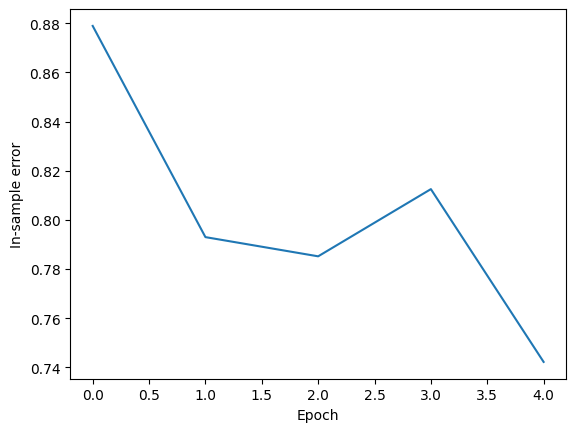

In [17]:
MLP_Training = Gradient_Trainer(MLP,mnist_train_iter,MLP_loss,MLP_trainer,mnist_test_iter)
MLP_Training.Train(5,True,True,True)